<a href="https://colab.research.google.com/github/yuriarciniegas/yoaprendo1/blob/master/GPT2_Slogans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

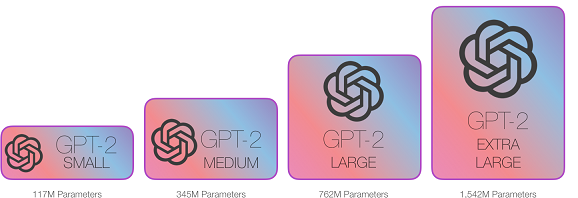

**GPT-2 Slogan Generator**

https://jonathanbgn.com/gpt2/2020/01/20/slogan-generator.html

**Step 0: Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Step 1: Install HuggingFace transformers library**

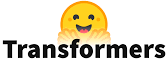

Hugging Face offers several functions to work with transformers and pre-trained models

In [ ]:
!pip install transformers

**Step 2: Load a pre-trained model**

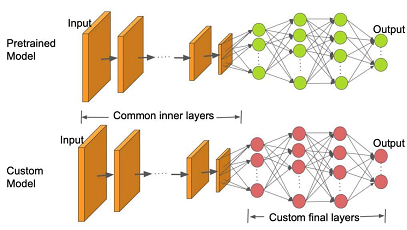

A language model is a model trained to predict the probability distribution of the next token.

DistilGPT2 (short for Distilled-GPT2) is an English-language model pre-trained with the supervision of the smallest version of Generative Pre-trained Transformer 2 (GPT-2). Like GPT-2, DistilGPT2 can be used to generate text.

Each model uses its own tokenizer.

In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

#MODEL_NAME = 'distilgpt2'
#MODEL_NAME = 'datificate/gpt2-small-spanish'
MODEL_NAME = 'DeepESP/gpt2-spanish'

tokenizer = GPT2Tokenizer.from_pretrained(MODEL_NAME)

model = GPT2LMHeadModel.from_pretrained(MODEL_NAME)

**Step 3. Adapt the tokenizer**

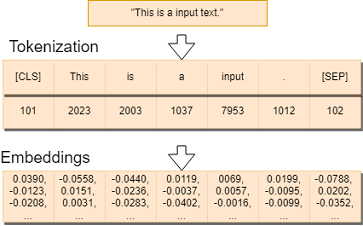

In [ ]:
# Declare special tokens for padding and separating the context from the slogan:
SPECIAL_TOKENS_DICT = {
    'pad_token': '<pad>',
    'additional_special_tokens': ['<context>', '<slogan>'],
}

tokenizer.add_special_tokens(SPECIAL_TOKENS_DICT)
model.resize_token_embeddings(len(tokenizer))

print(tokenizer.special_tokens_map)

#bos_token: begin of string
#eos_token: end of string
#unk_token: unknow
#pad_token: token to fill empty places.

**Step 4: Tokenize text and create dataset**

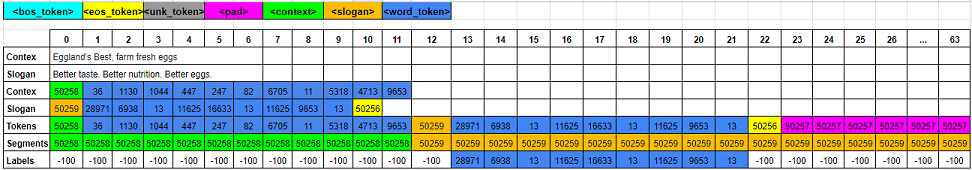

In [ ]:
import csv
import torch
from torch.utils.data import Dataset

class SloganDataset(Dataset):
  def __init__(self, filename, tokenizer, seq_length=64):

    context_tkn = tokenizer.additional_special_tokens_ids[0] #<context>
    slogan_tkn = tokenizer.additional_special_tokens_ids[1] #<slogan>
    pad_tkn = tokenizer.pad_token_id #<pad>
    eos_tkn = tokenizer.eos_token_id #<eos_token>

    self.examples = []
    i=0
    with open(filename) as csvfile:
      reader = csv.reader(csvfile)
      for row in reader:
        # Build the context and slogan segments:
        context = [context_tkn] + tokenizer.encode(row[0], max_length=seq_length//2-1)
        slogan = [slogan_tkn] + tokenizer.encode(row[1], max_length=seq_length//2-2) + [eos_tkn]

        # Concatenate the two parts together:
        tokens = context + slogan + [pad_tkn] * ( seq_length - len(context) - len(slogan) )

        # Annotate each token with its corresponding segment:
        segments = [context_tkn] * len(context) + [slogan_tkn] * ( seq_length - len(context) )

        # Ignore the context, padding, and <slogan> tokens by setting their labels to -100
        labels = [-100] * (len(context)+1) + slogan[1:] + [-100] * ( seq_length - len(context) - len(slogan) )

        '''
        if i<5:
          print("\nRow:")
          print(row)
          print("Row[0]:")
          print(row[0])
          print("Row[1]:")
          print(row[1])
          print("Context:")
          print(context)
          print("Slogan:")
          print(slogan)
          print("Tokens:")
          print(tokens)
          print("Segments:")
          print(segments)
          print("Labels:")
          print(labels)
          i=i+1
          '''

        # Add the preprocessed example to the dataset
        self.examples.append((tokens, segments, labels))

  def __len__(self):
    return len(self.examples)

  def __getitem__(self, item):
    return torch.tensor(self.examples[item])

# Build the dataset and display the dimensions of the 1st batch for verification:
slogan_dataset = SloganDataset('/content/drive/MyDrive/Deep_Learning_Colab/GPT2_PyTorch_Slogans/esloganes.csv', tokenizer)
print(next(iter(slogan_dataset)).size())

**Step 5. Generate train and validate dataset**

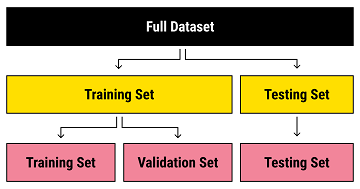

In [ ]:
import math, random
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

# Create data indices for training and validation splits:
indices = list(range(len(slogan_dataset)))

random.seed(42)
random.shuffle(indices)

split = math.floor(0.1 * len(slogan_dataset))
train_indices, val_indices = indices[split:], indices[:split]

# Build the PyTorch data loaders:
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(slogan_dataset, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(slogan_dataset, batch_size=64, sampler=val_sampler)

**Step 6. Function to fit the model**

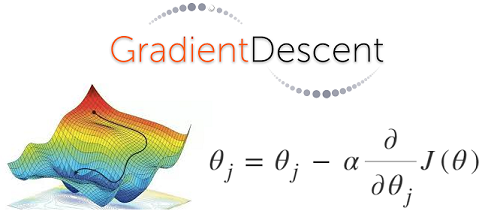

In [ ]:
import numpy as np

#tqdm is a simple library to display a progress bar.
from tqdm import tqdm

import time

def fit(model, optimizer, train_dl, val_dl, epochs=1, device=torch.device('cpu')):

  for i in range(epochs):

    print('\n--- Starting epoch #{} ---'.format(i))

    model.train() #it's fast.

    # These 2 lists will keep track of the batch losses and batch sizes over one epoch:
    losses = []
    nums = []

    for xb in tqdm(train_dl, desc="Training"):
      # Move the batch to the training device
      inputs = xb.to(device)

      #inputs is a tensor whit 3 matrix.
      #inputs[:,0,:] is a matrix with tokens for 32 samples
      #inputs[:,1,:] is a matrix with segments for 32 samples
      #inputs[:,2,:] is a matrix with labels for 32 samples
      #inputs.shape = [32, 3, 64]

      '''
      print("\n=======================NEW xb=========================\n")
      print(inputs.shape)
      print("inputs[:,0,:]")
      print(inputs[:,0,:])
      print("inputs[:,1,:]")
      print(inputs[:,1,:])
      print("inputs[:,2,:]")
      print(inputs[:,2,:])
      '''

      # Call the model with the token ids, segment ids, and the ground truth (labels)
      outputs = model(inputs[:,0,:], token_type_ids=inputs[:,1,:], labels=inputs[:,2,:])
      #outputs produces a big tensor. Don't print outputs!!

      # Add the loss and batch size to the list:
      loss = outputs[0]

      losses.append(loss.item())
      nums.append(len(xb))  #nums = [32,32...32]

      #backward() calculates the derivative dloss/dx for each parameter x.
      #these are accumulated into x.grad for every parameter x, namely: x.grad += dloss/dx
      loss.backward()

      #optimizer.step() updates the value of x using the gradient x.grad, namely: x += -lr * x.grad
      optimizer.step()

      #optimizer.zero_grad() clears x.grad for every parameter x in the optimizer.
      #It’s important to call this before loss.backward(), otherwise you’ll accumulate the gradients from multiple passes.
      model.zero_grad()

    # Compute the average cost over one epoch:
    train_cost = np.sum(np.multiply(losses, nums)) / sum(nums)

    # Now do the same thing for validation:

    model.eval() #it's fast.

    with torch.no_grad():
      losses = []
      nums = []

      for xb in tqdm(val_dl, desc="Validation"):
        inputs = xb.to(device)
        outputs = model(inputs[:,0,:], token_type_ids=inputs[:,1,:], labels=inputs[:,2,:])
        losses.append(outputs[0].item())
        nums.append(len(xb))

    val_cost = np.sum(np.multiply(losses, nums)) / sum(nums)

    print('\n--- Epoch #{} finished --- Training cost: {} / Validation cost: {}'.format(i, train_cost, val_cost))


**Step 7. Fine tuning**

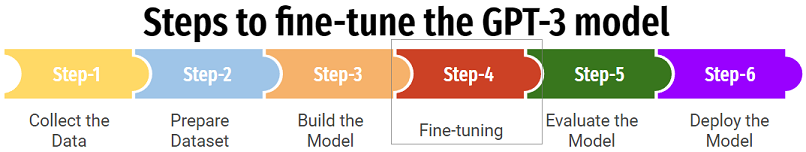

In [ ]:
from transformers import AdamW

# Move the model to the GPU:
device = torch.device('cuda')
model.to(device)

# Fine-tune GPT2 for two epochs:
optimizer = AdamW(model.parameters())
fit(model, optimizer, train_loader, val_loader, epochs=2, device=device)

**Step 8. Define Sampling Functions for Logits**

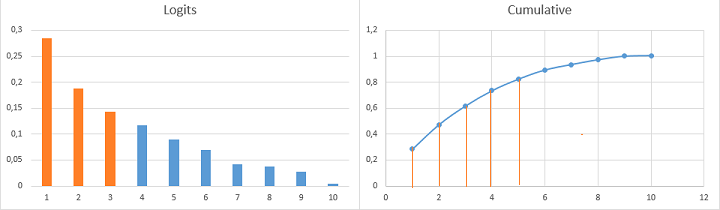

In [ ]:
# Sampling functions with top k and top p from HuggingFace:

import torch.nn.functional as F
from tqdm import trange

def top_k_top_p_filtering(logits, top_k=0, top_p=0.0, filter_value=-float('Inf')):
    """ Filter a distribution of logits using top-k and/or nucleus (top-p) filtering
        Args:
            logits: logits distribution shape (batch size x vocabulary size)
            top_k > 0: keep only top k tokens with highest probability (top-k filtering).
            top_p > 0.0: keep the top tokens with cumulative probability >= top_p (nucleus filtering).
                Nucleus filtering is described in Holtzman et al. (http://arxiv.org/abs/1904.09751)
        From: https://gist.github.com/thomwolf/1a5a29f6962089e871b94cbd09daf317
    """
    top_k = min(top_k, logits.size(-1))  # Safety check
    if top_k > 0:
        print("TOP_K>0")
        # Remove all tokens with a probability less than the last token of the top-k
        indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
        logits[indices_to_remove] = filter_value

    if top_p > 0.0:
        print("TOP_K>0")
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

        # Remove tokens with cumulative probability above the threshold
        sorted_indices_to_remove = cumulative_probs > top_p
        # Shift the indices to the right to keep also the first token above the threshold
        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
        sorted_indices_to_remove[..., 0] = 0

        # scatter sorted tensors to original indexing
        indices_to_remove = sorted_indices_to_remove.scatter(dim=1, index=sorted_indices, src=sorted_indices_to_remove)
        logits[indices_to_remove] = filter_value

    return logits


# From HuggingFace, adapted to work with the context/slogan separation:
def sample_sequence(model, length, context, segments_tokens=None, num_samples=1, temperature=1, top_k=0, top_p=0.0, repetition_penalty=1.0,
                    device='cpu'):
    context = torch.tensor(context, dtype=torch.long, device=device)
    context = context.unsqueeze(0).repeat(num_samples, 1)
    generated = context

    '''
    print("\ngenerated:")
    print(generated) #Generate 1 vector (context vector) repeated n times (num_samples)
    '''

    with torch.no_grad():
        for _ in trange(length): #to generate phrases of length=20 words.

            inputs = {'input_ids': generated} #generated adds a new token for each iteration.

            if segments_tokens != None:
              inputs['token_type_ids'] = torch.tensor(segments_tokens[:generated.shape[1]]).unsqueeze(0).repeat(num_samples, 1)

            '''
            print("\ninputs")
            print(inputs)
            '''

            outputs = model(**inputs)  # Note: we could also use 'past' with GPT-2/Transfo-XL/XLNet/CTRL (cached hidden-states)
            next_token_logits = outputs[0][:, -1, :] / (temperature if temperature > 0 else 1.)

            '''
            print('\nnext_token_logits')
            print(next_token_logits.shape)
            '''

            # repetition penalty from CTRL (https://arxiv.org/abs/1909.05858)
            for i in range(num_samples):
                for token in set(generated[i].tolist()):
                    next_token_logits[i, token] /= repetition_penalty

            filtered_logits = top_k_top_p_filtering(next_token_logits, top_k=top_k, top_p=top_p)

            '''
            print('\nfiltered_logits')
            print(filtered_logits)
            '''

            if temperature == 0: # greedy sampling:
                next_token = torch.argmax(filtered_logits, dim=-1).unsqueeze(-1)  #argmax returns the INDICES of the maximum value of all elements in the input tensor.
            else:
                next_token = torch.multinomial(F.softmax(filtered_logits, dim=-1), num_samples=1)

            '''
            print('\nnext_token')
            print(next_token)
            '''

            generated = torch.cat((generated, next_token), dim=1) #Add the new token to generated

    return generated


**Step 9. Use the tuned transformer to generate slogans**

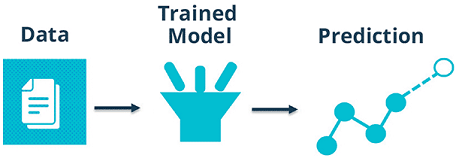

In [ ]:
context = "Restaurantes ingleses"

context_tkn = tokenizer.additional_special_tokens_ids[0]
slogan_tkn = tokenizer.additional_special_tokens_ids[1]

input_ids = [context_tkn] + tokenizer.encode(context)

segments = [slogan_tkn] * 64
segments[:len(input_ids)] = [context_tkn] * len(input_ids)

input_ids += [slogan_tkn]

'''
print("\ninputs_ids")
print(input_ids)
print("\nsegments")
print(segments)
'''

# Move the model back to the CPU for inference:
model.to(torch.device('cpu'))

# Generate num_samples samples of max length 20
generated = sample_sequence(model, length=20, context=input_ids, segments_tokens=segments, num_samples=10)

print('\n\n--- Generated Slogans ---\n')

for g in generated:
  slogan = tokenizer.decode(g.squeeze().tolist())
  slogan = slogan.split('<|endoftext|>')[0].split('<slogan>')[1]
  print(slogan)